In [253]:
import torch
from matplotlib import pyplot as plt
from matplotlib import rc
import numpy as np
import scipy.stats as stats

rc("font", **{"family": "Times"})
rc("text", usetex=True)
# plt.rcParams['figure.dpi']= 300
plt.rcParams['figure.dpi']= 150

# x = xr.open_dataset("pr_rcp85/pr_rcp85_land-cpm_birmingham-64_2.2km-coarsened-4x-2.2km-coarsened-4x_01_1hr_19801201-19801230.nc").pr.values.flatten()
# x = xr.open_dataset("pr_rcp85/pr_rcp85_land-cpm_birmingham-64_2.2km-coarsened-4x-2.2km-coarsened-4x_01_1hr_20660501-20660530.nc").pr.values.flatten()

x_sorted = torch.load("pr_rcp85_land-cpm_birmingham-64_2.2km-coarsened-4x-2.2km-coarsened-4x_01_1hr_flattened_sorted.pt").numpy()
y_sorted = np.sort(torch.load("samples.pt", map_location=torch.device('cpu')).numpy().flatten())

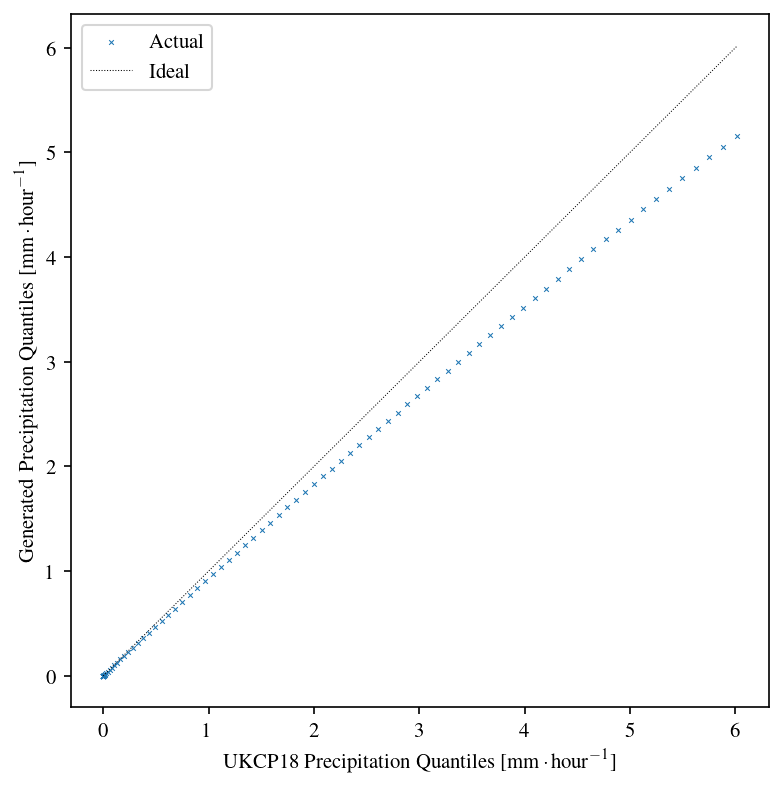

quantile: 0.0000, UKCP18: 0.0000, Generated: 0.0000
quantile: 0.0674, UKCP18: 0.0000, Generated: 0.0000
quantile: 0.1303, UKCP18: 0.0000, Generated: 0.0000
quantile: 0.1889, UKCP18: 0.0000, Generated: 0.0000
quantile: 0.2435, UKCP18: 0.0000, Generated: 0.0000
quantile: 0.2945, UKCP18: 0.0000, Generated: 0.0000
quantile: 0.3421, UKCP18: 0.0000, Generated: 0.0000
quantile: 0.3864, UKCP18: 0.0000, Generated: 0.0000
quantile: 0.4278, UKCP18: 0.0000, Generated: 0.0000
quantile: 0.4663, UKCP18: 0.0000, Generated: 0.0000
quantile: 0.5023, UKCP18: 0.0000, Generated: 0.0001
quantile: 0.5358, UKCP18: 0.0000, Generated: 0.0001
quantile: 0.5671, UKCP18: 0.0000, Generated: 0.0001
quantile: 0.5963, UKCP18: 0.0000, Generated: 0.0001
quantile: 0.6235, UKCP18: 0.0000, Generated: 0.0001
quantile: 0.6489, UKCP18: 0.0000, Generated: 0.0001
quantile: 0.6725, UKCP18: 0.0000, Generated: 0.0002
quantile: 0.6946, UKCP18: 0.0000, Generated: 0.0002
quantile: 0.7152, UKCP18: 0.0000, Generated: 0.0002
quantile: 0.

In [251]:
def get_quantiles(sorted_array, desired_quantiles):
    indices = (len(sorted_array) - 1) * desired_quantiles
    indices_floor = np.floor(indices).astype(int)
    indices_ceil = np.ceil(indices).astype(int)

    indices_fractional_part = indices - indices_floor

    quantiles_floor = sorted_array[indices_floor]
    quantiles_ceil = sorted_array[indices_ceil]

    quantiles = quantiles_floor + indices_fractional_part * (quantiles_ceil - quantiles_floor)

    return quantiles

# desired_quantiles = np.concatenate([np.linspace((1 - 10 ** (i + 1)) + (10 ** i), (1-10**i), 9) for i in range(-1, -8, -1)])
desired_quantiles = 1 - np.geomspace(1, 0.0001, 100)
# plt.plot(desired_quantiles)
# plt.show()

x_quantiles = get_quantiles(x_sorted, desired_quantiles)
y_quantiles = get_quantiles(y_sorted, desired_quantiles)

plt.figure(figsize=(6, 6))
plt.scatter(x_quantiles, y_quantiles, marker = 'x', s = 5, linewidth = 0.5, label = "Actual")
plt.plot(x_quantiles, x_quantiles, linewidth = 0.5, linestyle=":", c = "black", label = "Ideal")
plt.legend()

plt.xlabel('UKCP18 Precipitation Quantiles [$\mathrm{mm}\cdot\mathrm{hour}^{-1}$]')
plt.ylabel('Generated Precipitation Quantiles [$\mathrm{mm}\cdot\mathrm{hour}^{-1}$]')

plt.show()

for quantile, x_quantile, y_quantile in zip(desired_quantiles, x_quantiles, y_quantiles):
    print(f"quantile: {quantile:.4f}, UKCP18: {x_quantile:.4f}, Generated: {y_quantile:.4f}")